准备数据

2.2.0
2.3.0-tf


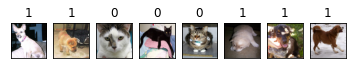

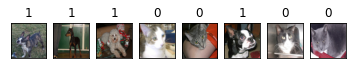

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.keras.__version__)

batch_size = 8
buffer_size = 5000
dataset = tfds.load("cats_vs_dogs", split=tfds.Split.TRAIN, as_supervised=True)
dataset = dataset.map(lambda img, label: (tf.image.resize(img, [224, 224]) / 255.0, label)) \
    .shuffle(buffer_size) \
    .batch(batch_size)


sub_dataset = dataset.take(2)

for images, labels in sub_dataset:
  fig, axs = plt.subplots(1, batch_size)
  for i in range(batch_size):
    axs[i].set_title(labels.numpy()[i])
    axs[i].imshow(images.numpy()[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
  plt.show()

定义模型

In [2]:
def vgg16_model(input_shape=(224, 224, 3)):
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                          weights='imagenet',
                          input_shape=input_shape)
    for layer in vgg16.layers:
      layer.trainable = False
    
    last = vgg16.output

    x = tf.keras.layers.Flatten()(last)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=vgg16.input, outputs=x)
    model.summary()

    return model

model = vgg16_model()
model.compile(optimizer='adam',
       loss="sparse_categorical_crossentropy",
       metrics=['accuracy'])


    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
epochs = 5

train = dataset.take(1000)
validation = dataset.take(200)
train_history = model.fit(train, epochs=epochs, verbose=1, 
              validation_data=validation)

Epoch 1/5
1000/1000 [==============================] - 61s 61ms/step - loss: 0.4818 - accuracy: 0.7667 - val_loss: 0.2974 - val_accuracy: 0.9025
Epoch 2/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.3249 - accuracy: 0.8508 - val_loss: 0.1863 - val_accuracy: 0.9200
Epoch 3/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.2629 - accuracy: 0.8756 - val_loss: 0.1449 - val_accuracy: 0.9406
Epoch 4/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.2317 - accuracy: 0.8900 - val_loss: 0.1105 - val_accuracy: 0.9594
Epoch 5/5
1000/1000 [==============================] - 59s 59ms/step - loss: 0.2115 - accuracy: 0.8949 - val_loss: 0.1288 - val_accuracy: 0.9425


模型存储


In [4]:
!pip install pyyaml
!mkdir ./models
yaml_string = model.to_yaml()
with open('./models/cat_dog.yaml', 'w') as model_file:
  model_file.write(yaml_string)
model.save_weights('./models/cat_dog.h5')
!ls ./models
!cat ./models/cat_dog.yaml

mkdir: cannot create directory ‘./models’: File exists
cat_dog.h5  cat_dog.yaml
backend: tensorflow
class_name: Model
config:
  input_layers:
  - [input_1, 0, 0]
  layers:
  - class_name: InputLayer
    config:
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      dtype: float32
      name: input_1
      ragged: false
      sparse: false
    inbound_nodes: []
    name: input_1
  - class_name: Conv2D
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {}
      bias_regularizer: null
      data_format: channels_last
      dilation_rate: &id001 !!python/tuple [1, 1]
      dtype: float32
      filters: 64
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {seed: null}
      kernel_regularizer: null
      kernel_size: !!python/tuple [3, 3]
      name: block1_conv1
      padding: same
      strides: &id002 !!python/tu

模型装载

In [14]:
with open("./models/cat_dog.yaml") as yamlfile:
  loaded_model = yamlfile.read()

model=tf.keras.models.model_from_yaml(loaded_model)
model.load_weights("./models/cat_dog.h5")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

[[5.6812674e-02 9.4318730e-01]
 [9.9892223e-01 1.0778137e-03]
 [6.8158931e-03 9.9318415e-01]
 [9.9877220e-01 1.2277634e-03]
 [9.9918014e-01 8.1988174e-04]
 [6.7211546e-02 9.3278849e-01]
 [9.9327350e-01 6.7265052e-03]
 [3.0252602e-04 9.9969745e-01]]
tf.Tensor([1 0 1 0 0 1 0 1], shape=(8,), dtype=int64)
[1 0 1 0 0 1 0 1]
[ True  True  True  True  True  True  True  True]


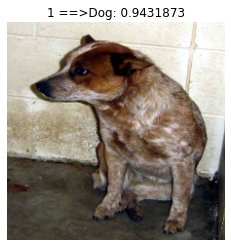

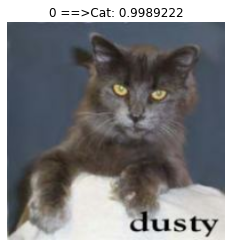

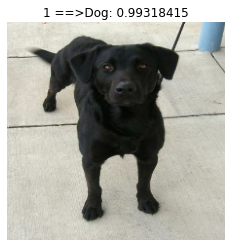

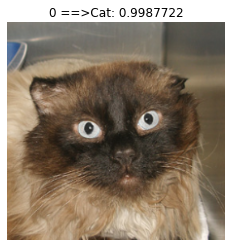

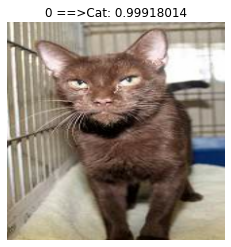

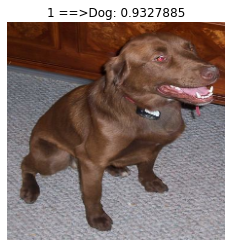

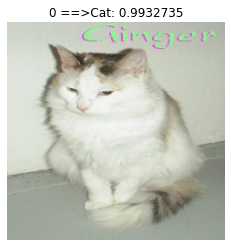

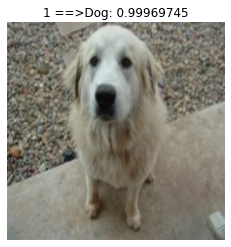

In [15]:
import numpy as np
sub_dataset = dataset.take(1)


for image, label in sub_dataset:
  preds = model.predict(image)
  print(preds)
  print(label)
  print(np.argmax(preds, axis=1))
  print(np.argmax(preds, axis=1) == label.numpy())
  
  for i in range(batch_size):
    #pred = model.predict(image.numpy()[i])
    if (np.argmax(preds[i])==0):
      label_out = str(label.numpy()[i]) + " ==>Cat: " + str(preds[i][0])
    else:
      label_out = str(label.numpy()[i]) + " ==>Dog: " + str(preds[i][1])

    plt.title(label_out)
    plt.imshow(image.numpy()[i])
    plt.axis('off')
    plt.show()


  

### 

Dataset 数据集元素访问

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
X = tf.constant([100,102,103])
Y = tf.constant([1,2,3])
dataset = tf.data.Dataset.from_tensor_slices((X,Y))
for x,y in dataset:
  print(x.numpy(), y.numpy())

100 1
102 2
103 3


In [5]:
import os
from PIL import Image

def validfile(path, filename):
  valid = False
  try:
    image = Image.open(path+ file)
    valid = True
  except:
    pass
  return valid

path = "./PetImages/"
for file in os.listdir(path + 'Dog'):
    if not validfile(path + "Dog/", file):
      print(file)

image_string = tf.io.read_file("./PetImages/Cat/6211.jpg")
print(image_string)
image_decoded = tf.image.decode_jpeg(image_string)

Thumbs.db


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

11702.jpg
tf.Tensor(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x002\x10\x00\x02\x02\x02\x02\x02\x01\x04\x02\x00\x06\x01\x04\x03\x00\x00\x00\x01\x02\x11\x03!\x121\x04A\x05\x13"Qa2q\x06\x14#B\x81\xa13\x15R\x91\xb1$\xc1\xd1\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x03\x04\x05\xff\xc4\x00"\x11\x01\x01\x01\x00\x03\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x01\x11\x02!1\x12A\x03Q\x04aq"#\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x1

定义数据读取函数

In [0]:
import os
def validfile(path, filename):
  valid = False
  try:
    image = Image.open(path+ file)
    valid = True
  except:
    pass
  return valid

def read_image_filenames(data_dir):
  cat_dir = data_dir + "Cat/"
  dog_dir = data_dir + "Dog/"
  cats = [cat_dir + fn  for fn in os.listdir(cat_dir) if validfile(cat_dir, fn)]
  dogs = [dog_dir + fn  for fn in os.listdir(dog_dir) if validfile(dog_dir, fn)]
  cat_filenames = tf.constant(cats[:300])
  dog_filenames = tf.constant(dogs[-300:])
  #for i, filename in enumerate(cat_filenames[763:800]):
  #  print(i, filename)

  filenames = tf.concat([cat_filenames, dog_filenames], axis=-1)
  print(filenames)
  labels = tf.concat([
        tf.zeros(cat_filenames.shape, dtype=tf.int32),
        tf.ones(cat_filenames.shape, dtype=tf.int32)
  ],axis=-1)
  return filenames,labels


def decode_image_and_resize(filename, label):
  print(filename)
  image_string = tf.io.read_file(filename)
  print(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded,[224,224]) / 255.0
  return image_resized, label

def prepare_dataset(data_dir, buffer_size=100, batch_size=8):
  filenames, labels = read_image_filenames(data_dir)
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

  #subdata = dataset.take(3)

  #for x, y in subdata:
  #  print(x.numpy(), y)

  dataset = dataset.map(map_func=decode_image_and_resize,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE
                        )

  #subdata = dataset.take(1)
  #for x, y in subdata:
  #  print(x.shape, y.numpy())
  #  print(x)
  #  plt.title(y.numpy())
    
  #  plt.imshow(x.numpy())
  #  plt.show()

  dataset = dataset.shuffle(buffer_size)

  #sub_dataset = dataset.take(3)
  #for x,y in sub_dataset.take(3):
  #  plt.title(y.numpy())
  #  plt.imshow(x.numpy())
  #  plt.show()
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset



In [0]:
decode_image_and_resize(".//PetImages//Cat//8024.jpg", 0)

.//PetImages//Cat//8024.jpg


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.6842174 , 0.62931544, 0.37441352],
         [0.6567314 , 0.6018294 , 0.34692752],
         [0.6722864 , 0.61346287, 0.35856092],
         ...,
         [0.49283963, 0.4222514 , 0.13989846],
         [0.49059072, 0.4233288 , 0.15452635],
         [0.4956233 , 0.42503506, 0.16621153]],
 
        [[0.6840861 , 0.6291841 , 0.3742822 ],
         [0.65328044, 0.5944569 , 0.33955494],
         [0.66198355, 0.60221463, 0.3476278 ],
         ...,
         [0.48222163, 0.4116334 , 0.12928046],
         [0.486826  , 0.41956407, 0.15076165],
         [0.49712896, 0.42654073, 0.16771719]],
 
        [[0.6870798 , 0.6294905 , 0.37458858],
         [0.6541754 , 0.5953519 , 0.3404499 ],
         [0.6633549 , 0.59617186, 0.34405637],
         ...,
         [0.48133755, 0.40537465, 0.12570904],
         [0.4829482 , 0.41609418, 0.14606802],
         [0.49712896, 0.42922804, 0.16234253]],
 
        ...,
 
        [[0.73279786, 0.7367194 

In [0]:
train_data_dir = "./PetImages/"
filenames , labels = read_image_filenames(train_data_dir)
dataset = tf.data.Dataset.from_tensor_slices((filenames,labels))
subdata = dataset.take(3)

for x, y in subdata:
    print(x.numpy(), y)

b'./PetImages/Cat/5011.jpg' tf.Tensor(0, shape=(), dtype=int32)
b'./PetImages/Cat/10014.jpg' tf.Tensor(0, shape=(), dtype=int32)
b'./PetImages/Cat/925.jpg' tf.Tensor(0, shape=(), dtype=int32)


查看前几项数据

In [0]:
dataset = dataset.map(
    map_func = decode_image_and_resize,
    num_parallel_calls = tf.data.experimental.AUTOTUNE
)



(224, 224, 3) 0
tf.Tensor(
[[[0.1306375  0.1306375  0.0914218 ]
  [0.12015931 0.10839461 0.07310049]
  [0.14957109 0.13325457 0.08619574]
  ...
  [0.4483806  0.38955706 0.2601453 ]
  [0.4483806  0.38955706 0.2601453 ]
  [0.4483806  0.38955706 0.2601453 ]]

 [[0.13871674 0.13871674 0.09950105]
  [0.12668067 0.11491597 0.07962185]
  [0.16001402 0.14369749 0.09667892]
  ...
  [0.4549895  0.39616597 0.2667542 ]
  [0.45494574 0.39612222 0.26671043]
  [0.45494574 0.39612222 0.26671043]]

 [[0.13277544 0.12471348 0.08818512]
  [0.13164744 0.11719539 0.07652663]
  [0.15979807 0.14348155 0.10002916]
  ...
  [0.4654324  0.40660888 0.28257176]
  [0.46151084 0.4026873  0.2786502 ]
  [0.46151084 0.4026873  0.2786502 ]]

 ...

 [[0.6431373  0.57991827 0.4519282 ]
  [0.64687145 0.582892   0.4571833 ]
  [0.6521155  0.5860791  0.4710175 ]
  ...
  [0.5992993  0.45059478 0.2574926 ]
  [0.57613766 0.43674698 0.23223016]
  [0.55922586 0.42981413 0.22197098]]

 [[0.6431373  0.5764975  0.46174738]
  [0.64705

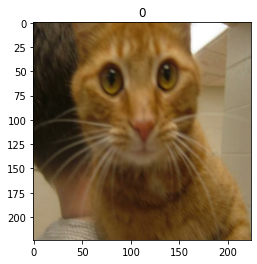

In [0]:
subdata = dataset.take(1)
for x, y in subdata:
    print(x.shape, y.numpy())
    print(x)
    plt.title(y.numpy())
    
    plt.imshow(x.numpy())

**shuffle**

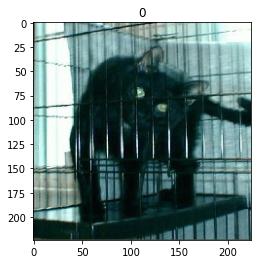

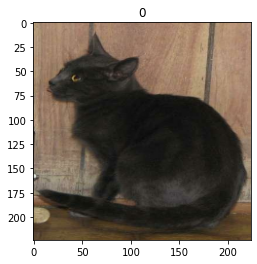

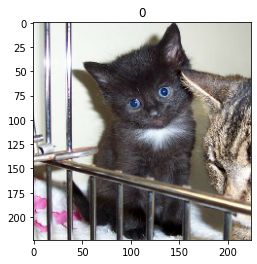

In [0]:
buffer_size = 100
dataset = dataset.shuffle(buffer_size)
sub_dataset = dataset.take(3)
for x,y in sub_dataset.take(3):
    plt.title(y.numpy())
    plt.imshow(x.numpy())
    plt.show()

**batch**

In [0]:
batch_size = 8
dataset_batch = dataset.batch(batch_size)
print(dataset_batch)
sub_dataset = dataset_batch.take(1)

for x,y in sub_dataset:
  print(x.shape)

<BatchDataset shapes: ((None,), (None,)), types: (tf.int32, tf.int32)>
(3,)


### 1.2 读取训练数据并处理 


In [0]:
 train_data_dir = "./PetImages/"
 buffer_size = 600
 batch_size = 8
 dataset_train = prepare_dataset(train_data_dir, buffer_size, batch_size)
 dataset_train

### 1.3 查看数据




In [8]:
sub_dataset = dataset_train.take(2)
#print(sub_dataset)
#for x,y in dataset_train:
# print(images.shape)
#fig = plt.figure(figsize=(20, 2))
for images, labels in sub_dataset:
  fig, axs = plt.subplots(1, batch_size)
  for i in range(batch_size):
    axs[i].set_title(labels.numpy()[i])
    axs[i].imshow(images.numpy()[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
  plt.show()

InvalidArgumentError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [0]:
!unzip kagglecatsanddogs_3367a.zip

In [0]:
!ls ./PetImages/Cat

In [0]:
!rm ./PetImages/Cat/Thumbs.db 